In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# from model import *
# from data_loader import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
import numpy as np
from kaldiio import ReadHelper
from sklearn.manifold import TSNE

# Training settings
from Process_Data.constants import cValue_1
from kaldiio import load_mat

matplotlib.rcParams.update({'errorbar.capsize': 5})

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_dir = '/home/yangwenhao/local/project/SpeakerVerification-pytorch'
sid_length = 7
num_spk = 7

In [7]:

scp_file = data_dir + '/Data/xvector/ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_rop/Mean_batch256_seblock_red2_downk3_avg5_ASTP2_em256_dp01_alpha0_none1_wd5e4_vares_bashuf/123456/vox1_test_var/test/xvectors.scp'
vects = {}

with open(scp_file, 'r') as f:
    for l in f.readlines():
        uid, upath = l.split()
        vects[uid] = load_mat(data_dir + '/' + upath)
        
# with ReadHelper('scp:%s'% scp_file) as reader:
#     for key, numpy_array in reader:
#         vects[key] = numpy_array

spks = []
for key in vects:
    s = key[:sid_length]
    if s not in spks:
        spks.append(s)

spks.sort()
spks_this = spks[:num_spk] if len(spks) > num_spk else spks
spk2vec = {}
for s in spks_this:
    spk2vec[s] = []
for key in vects:
    if key[:sid_length] in spks_this:
        this_vec = vects[key]
        vec_len = len(this_vec)
        spk2vec[key[:sid_length]].append(this_vec.reshape(1, vec_len))

all = []
all_len = [0]
for spk in spk2vec:
    spk_con = np.concatenate(spk2vec[spk])
    all_len.append(len(spk_con))
    all.append(spk_con)

all = np.concatenate(all, axis=0)
S_embedded = TSNE(n_components=2).fit_transform(all)

emb_group = []
for i in range(len(all_len)-1):
    start = np.sum(all_len[:(i+1)]).astype(np.int32)
    stop = np.sum(all_len[:(i+2)]).astype(np.int32)
    this_points = S_embedded[start:stop]
    assert len(this_points)>0, 'start:stop is %s:%s' %(start, stop)
    emb_group.append(this_points)

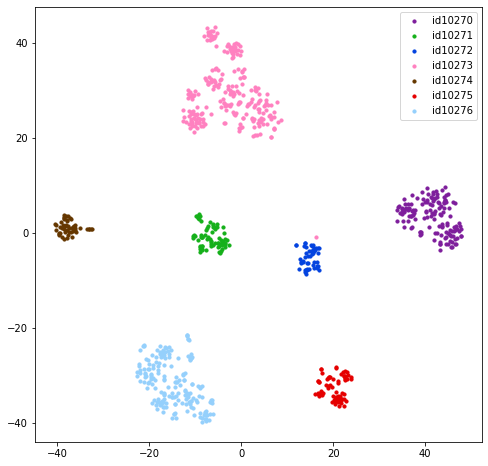

In [10]:
plt.figure(figsize=(8,8))
leng = []
for idx, group in enumerate(emb_group) :
    if len(group)>0:
        c = cValue_1[idx]
        leng.append(spks_this[idx])
        plt.scatter(group[:,0], group[:, 1], color=c, s=10)

plt.legend(leng, loc="best")

plt.savefig("./tsne.pdf", format="pdf")
plt.show()